In [3]:
%pip install -Uq langchain langchain-chroma "unstructured[all-docs]" pydantic lxml langchainhub
%pip install -Uq python_dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.8 MB/s eta 0:00:00


In [11]:
path =  "/content/rag-chat/test_data.pdf"

In [18]:
!apt-get install poppler-utils
! apt install tesseract-ocr
! apt install libtesseract-dev
!pip install -Uq pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [22]:
from typing import Any
import pytesseract
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

In [23]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [25]:
chunks[0].metadata.orig_elements

In [27]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '451411f4-f7bd-453b-bb8f-d452c1f625fc',
 'text': "Earnings and Unemployment Rates by Educational Attainment Unemployment rate in 2013 (%) Median weekly earnings in 2013 ($) Doctoral degree Professional degree Master’s degree Bachelor’s degree 1 Md n = *s ' oa 1 1 1 ' ' at 1 1 ' ’ SS Associate’s degree Some college, no degree High school diploma Less than a high school diploma All workers: 6.1% All workers: $827 Source: Bureau of Labor Statistics, 2014.",
 'metadata': {'coordinates': {'points': ((200.0, 500.0000000000001),
    (200.0, 1487.3333333333335),
    (2016.6666666666665, 1487.3333333333335),
    (2016.6666666666665, 500.0000000000001)),
   'system': 'PixelSpace',
   'layout_width': 2200,
   'layout_height': 1700},
  'last_modified': '2024-12-16T07:20:01',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 2,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5P

In [28]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [29]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

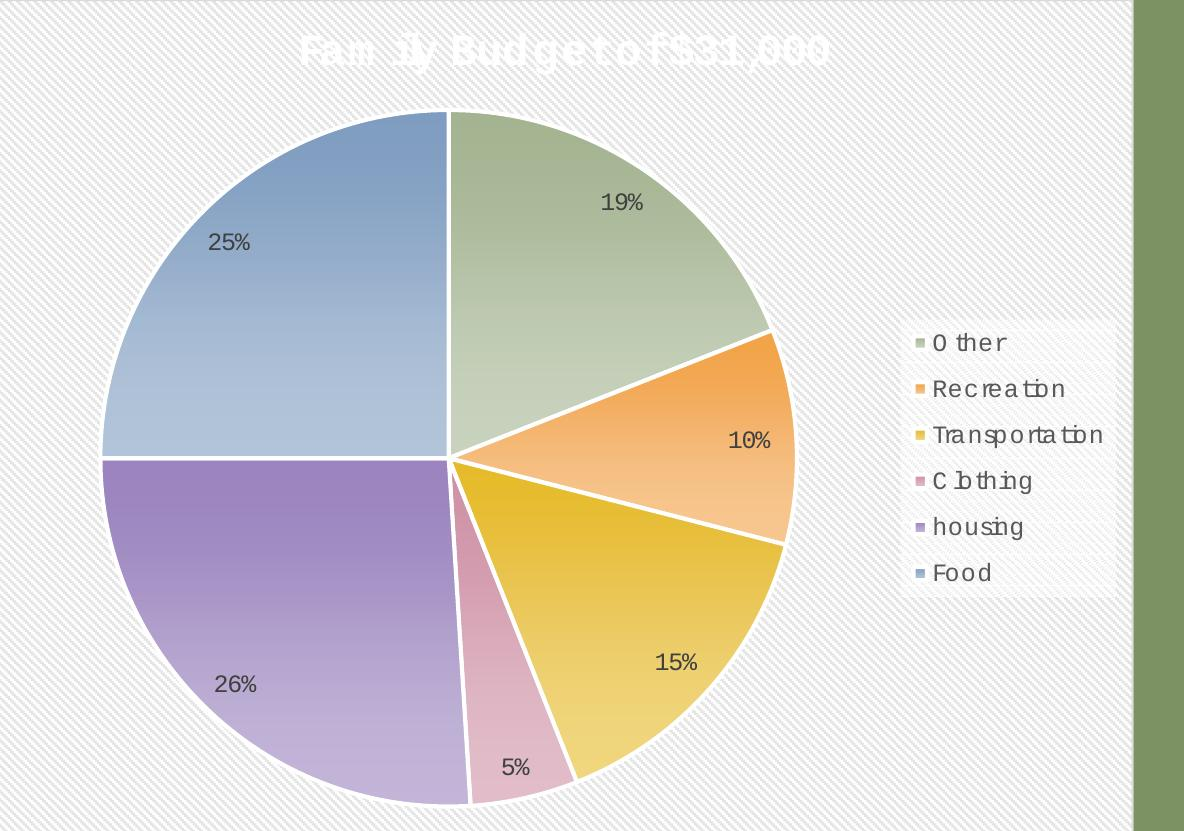

In [32]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[2])

In [33]:
%pip install -Uq langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 4.8 MB/s eta 0:00:00


In [34]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [38]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')


In [39]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [51]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})
table_summaries

[]

In [41]:
text_summaries

['The table shows the unemployment rate and median weekly earnings in the US by educational attainment in 2013. Charts and graphs are used to visualize data, which can be generated, gathered from an experiment, or collected from a source. Examples include tables, charts, and pie charts showing US GDP by industry and sector in 2010-2015.',
 'The text discusses the different types of graphs, including pie charts, bar graphs, and line graphs, and when to use each. It also explains how to use these graphs to compare data, such as US GDP, and how to plot data from a table. Additionally, it touches on linear regression and how to fit data to a line when it is not generated by a linear equation.',
 'This table appears to be a Life Expectancy at Birth table with data from 1925 to 2005 for men and women.\n\nThe life expectancy of men has changed the most since 1925.\n\nIn 1925, women were expected to live about 5 years longer than men.\n\nThe affiliations for Republicans and Independents were t

In [42]:
%pip install -Uq langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.6 MB/s eta 0:00:00


In [43]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [44]:
image_summaries

['The image presents two bar plots comparing unemployment rates and median weekly earnings in 2013 based on educational attainment. \n\n### Left Bar Plot: Unemployment Rate in 2013 (%)\n- **Title**: "Unemployment rate in 2013 (%)"\n- **Layout**: The plot is vertically oriented with bars representing different educational levels.\n- **Bars**:\n  - **Doctoral degree**: 2.2%\n  - **Professional degree**: 2.3%\n  - **Master\'s degree**: 3.4%\n  - **Bachelor\'s degree**: 4.0%\n  - **Associate\'s degree**: 5.4%\n  - **Some college, no degree**: 7.0%\n  - **High school diploma**: 7.5%\n  - **Less than a high school diploma**: 11.0%\n- **Reference**: The overall unemployment rate for all workers is noted at 6.1%.\n\n### Right Bar Plot: Median Weekly Earnings in 2013 ($)\n- **Title**: "Median weekly earnings in 2013 ($)"\n- **Layout**: This plot is also vertically oriented, with bars showing median earnings for the same educational levels.\n- **Bars**:\n  - **Doctoral degree**: $1,623\n  - **Pr

In [45]:
print(image_summaries[1])

The image displays a pie chart illustrating the distribution of the U.S. GDP in 2015, represented in percentages. The chart is segmented into four distinct categories, each color-coded for clarity:

1. **Manufacturing**: This segment occupies the largest portion of the chart, accounting for **59%** of the GDP. It is represented in **blue**.

2. **Finance, Insurance, Real Estate, Rental, and Leasing**: This category is marked in **red** and constitutes **18%** of the GDP.

3. **Arts, Entertainment, Recreation, Accommodation, and Food Services**: Depicted in **green**, this segment makes up **4%** of the GDP.

4. **Other**: This segment, shown in **purple**, accounts for **19%** of the GDP.

The chart is titled "2015 U.S. GDP (in millions of dollars)" and includes percentage labels within each segment for easy comprehension. The design is straightforward, focusing on the visual representation of economic contributions by sector.


In [47]:
%pip install -Uq langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.6 MB/s eta 0:00:00


VECTOR STORE

In [49]:
import uuid
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [52]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

#  Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [53]:
# Retrieve
docs = retriever.invoke(
    "What is the source of GDP data ?"
)

In [54]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALzBOoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo

In [55]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [58]:
response = chain.invoke(
    "how much does the manufacturing industry contibute in the year 2010 ?"
)

print(response)

In the year 2010, the manufacturing industry contributed approximately $4,992,521 million (or about $4.99 trillion) to the U.S. GDP.


Response: In 2015, the GDP data for various industries in the U.S. shows the following contributions:

1. **Finance, Insurance, Real Estate, Rental, and Leasing**: 59%
2. **Manufacturing**: 19%
3. **Arts, Entertainment, Recreation, Accommodation, and Food Services**: 18%
4. **Other**: 4%

From this data, it's clear that the finance and insurance sector dominates the GDP, accounting for a substantial majority at 59%. Manufacturing contributes significantly but is much smaller at 19%. The arts and entertainment sector follows closely behind, contributing 18%, while other industries combined make up only 4%.

This pie chart representation illustrates how these sectors compare relative to one another, highlighting the predominance of finance in the overall economic landscape in 2015.


Context:
Other

4%

Pie charts can be misleading when the slices do not correspond with the percent contribution to the whole pie. Notice the pie chart below is not very intuitive.

2015 U.S. GDP (in million

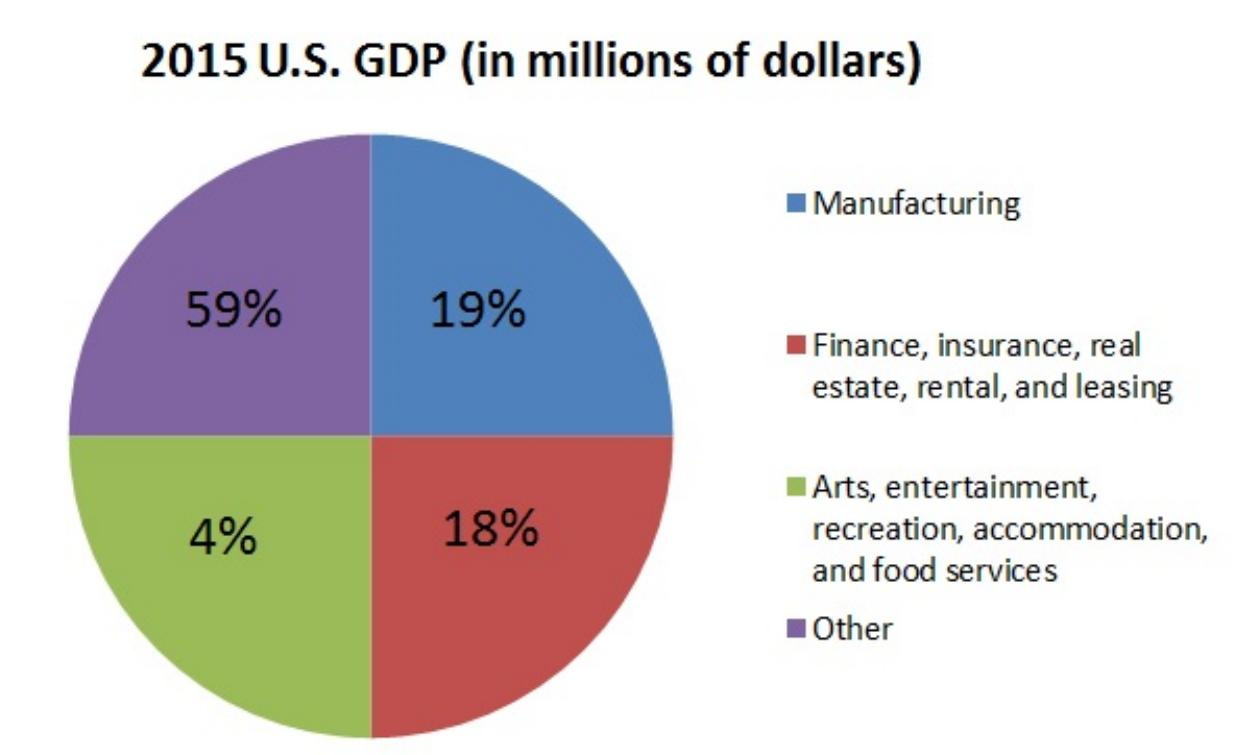

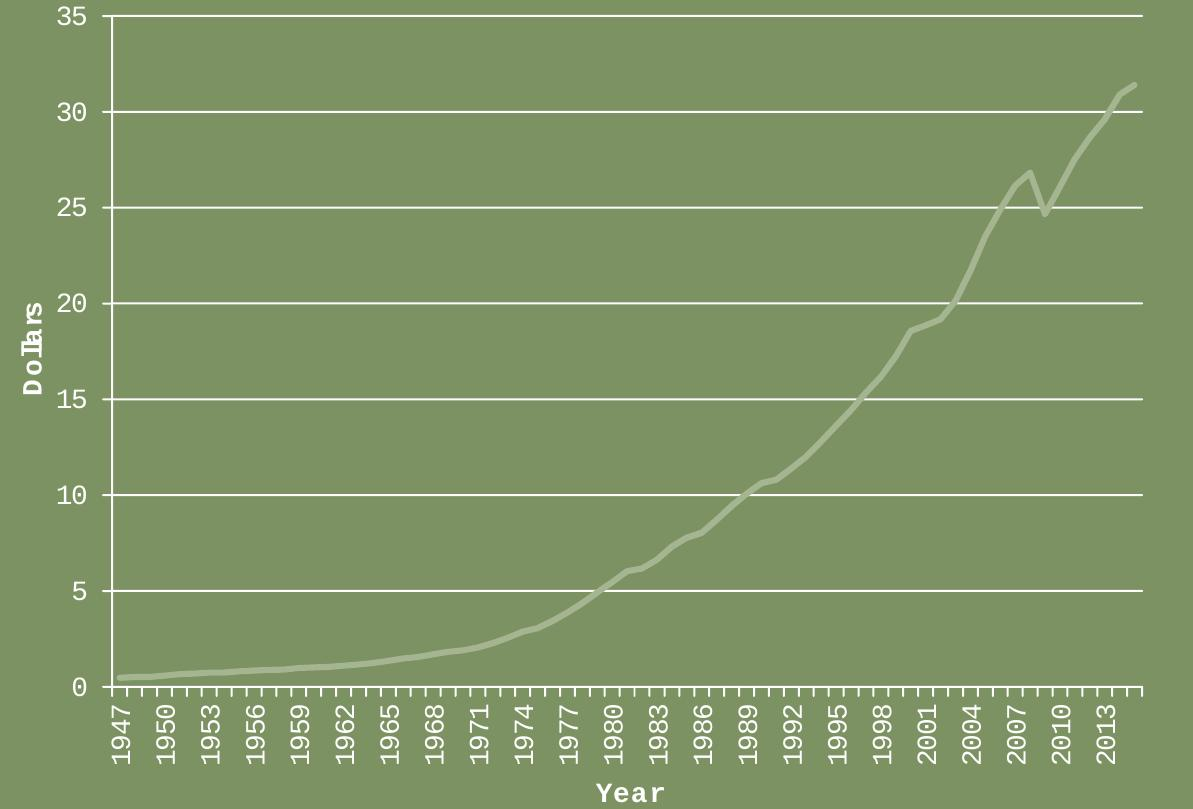

In [61]:
response = chain_with_sources.invoke(
    "Compare GDP data across various industries in the year 2015?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)